In [56]:
import scipy.special as spec
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import datetime
import sys
import glob
import os 
from scipy.optimize import minimize
from scipy.special import factorial
from tqdm import tqdm
import pickle

In [70]:
test = multi_tester(['LLH_detector'], tracks = 200, cascades = 70)
test.run(10000, 10, "1:00:00", signal_trials = 1000, ninj_tracks = 3, ninj_cascades = 2)

('multitester_20210519143039861741_BKG.npz',
 'multitester_20210519143039861741_SIGMA.npz')

In [69]:
class multi_tester():
    
    def __init__(self, methods, tracks, cascades):
        
        #list of method names exactly as they are written in the package (ex "LLH_detector")
        self.Methods = methods
        
        #number of mc background tracks and cascades to create background TS for and test with
        #will be consistent for everything this object is used for
        self.track_count = tracks
        self.cascade_count = cascades
        return
    
    def __str__(self):
        return
    
    '''
    Inputs: # of trials, # of files to split into, runtime for each file
            injection counts, injection angle, 
    Writes sb files for each event, repackage sb, and the sdag to control them-- runs these
    Returns: Background filename, Significances filename  
    
    Both the background TS distribution creation and an array of significances tested against the background
    Choose so many things in this function 
    '''
    def run(self, bkg_trials, filecount, runtime, mem = '50G', signal_trials = 0, ninj_tracks = 0, ninj_cascades = 0, outpath = './results/', clean = True):
        
        if type(runtime) != type(''):
            raise ValueError('Input runtime as a string of the form hr:min:seconds (ex 5:00:00 for 5 hours)')
            return
        
        #all files will be created in ./WIP and so add ../ to make outpath relative to the main directory
        self.outpath = '../' + outpath
        
        self.timetag = ("".join(filter(str.isdigit, str(datetime.datetime.now()))))
        self.pkl = 'multitester_' + self.timetag + '.pkl'
        
        #number of events per job
        self.nper= bkg_trials//filecount
        #write bkg sbatchs
        filnam="multitester" + self.timetag
        self.name = filnam
        for i in range(filecount):
            filstr=filnam+"_"+str(i)+".sb"
            f = open('./templates/bkgjob.txt', 'r')
            filetxt = f.read().format(time = runtime, mem = mem, tasknm = 'multitester_' + self.timetag, obj = self.pkl)
            f.close()
            f = open('./working/' +filstr, 'w+')
            f.write(filetxt)
            f.close()
            
        #write repackage sbatch
        f = open('./templates/repack.txt', 'r')
        filetxt = f.read().format(tasknm = 'multitester_' + self.timetag + '_REPACK', obj = self.pkl)
        f.close()
        f = open('./working/repack_' + filnam + '.sb', 'w+')
        f.write(filetxt)
        f.close()
        
        #write clean script sbatch
        f = open('./templates/clean.txt', 'r')
        filetxt = f.read().format(tasknm = 'multitester_' + self.timetag + '_CLEAN', obj = self.pkl)
        f.close()
        f = open('./working/clean_' + filnam + '.sb', 'w+')
        f.write(filetxt)
        f.close()
        
        
        #case where width based significance calculation is triggered-- else can be done explicitly in a script after backround distribution is created
        if signal_trials:
            #a few checks
            if min([bkg_trials, filecount, signal_trials, ninj_tracks, ninj_cascades]) < 0:
                raise ValueError('Some inputted value is negative')
                return 
            if ninj_tracks == 0 and ninj_cascades == 0:
                raise ValueError('Please input a number of tracks and cascades to inject for signal trials')
                return
            
            self.ninj_t = ninj_tracks
            self.ninj_c = ninj_cascades
            
            #write signal sbatch 
            f = open('./templates/signaljob.txt', 'r')
            filetxt = f.read().format(time = runtime, mem = mem, tasknm = 'multitester_signal_' + self.timetag, obj = self.pkl)
            f.close()
            f = open('./working/signal_' + filnam + '.sb', 'w+')
            f.write(filetxt)
            f.close()
            
            #write signal summation sbatch
            f = open('./templates/signal_summation.txt', 'r')
            filetxt = f.read().format(time = runtime, mem = mem, tasknm = 'multitester_' + self.timetag + '_SIGNAL', obj = self.pkl)
            f.close()
            f = open('./working/sigsum_' + filnam + '.sb', 'w+')
            f.write(filetxt)
            f.close()
            
        #WRITE SDAG-----------
        #str of jobs and their sdag names
        joblist = ''
        #str of each bkgTS dist creating job for calling as parents/children
        jstr = ''

        for i in range(filecount):
            joblist += f'JOB J{i} ./working/{filnam}_{i}.sb\n'
            jstr += f'J{i} '
        joblist += f'JOB RP ./working/{filnam}_rp.sb\n'
        joblist += f'JOB CLEAN ./working/{filnam}_clean.sb\n'
            
        if signal_trials:
            joblist += f'JOB S ./working/signal_{filnam}.sb\n'
            joblist += f'JOB SRP ./working/{filnam}_srp.sb\n'
            
            contents = joblist + '\nPARENT S CHILD ' + jstr + '\nPARENT ' + jstr + 'CHILD R SRP'
            if clean:
                contents += '\nPARENT R SRP CHILD CLEAN'
        else: 
            contents = joblist + '\nPARENT ' + jstr + 'CHILD R' 
            if clean:
                contents += '\nPARENT R CHILD CLEAN'

        fout=open(f'./working/{filnam}.sdag',"w")
        fout.write(contents)
        fout.close()
        
        #saves this object in a pkl file to be read in by other scripts
        dbfile = open('multitester_' + self.timetag + '.pkl', 'wb+')
        pickle.dump(self, dbfile)                     
        dbfile.close()
        
        bkg_filename = 'multitester_' + self.timetag + "_BKG.npz"
        signal_filename = 'multitester_' + self.timetag + "_SIGMA.npz"
        
        #start the program 
        os.system(f'python2 sdag.py ./working/{filnam}.sdag')
            
        return bkg_filename, signal_filename
    

    '''
    Inputs: Background filename 
    Checks to make sure background method is the same as the initiated method 
    Returns: Nothing
    '''
    def load_bkg(self):
        return
    
    """
    Inputs: Injection information, "background specifications??" 
    Saves "sky" in the object (i.e. object.sky) in the form of all events in the trial
    Returns: Nothing
    """
    def create_sky(self):
        return 
    
    """
    Inputs: Location (theta,phi)
    Checks to make sure a sky has been created. Calculates the TS at the point in the sky saved
    Returns: TS at location
    """
    
    def calculate_TS(self):
        return 
    
    """
    Inputs: Location or TS (bool mode switch)
    Compares TS against a loaded background the calculate the significance level 
    Returns: sigma
    """
    def calculate_sigma(self):
        return 
    
    """
    Inputs: "background specifications??"
    Runs background trials for the method and prints out all the useful benchmarking info one would need to 
        calculate the stuff for background files 
    Returns: A useful benchmarking metric (time per N trials?)
    """
    def benchmarking(self):
        return 

In [2]:
#loads in parameters for an Energy function brought in from a plot in https://arxiv.org/pdf/1306.2309.pdf
params = np.array([[ 7.83668562e+13, -2.29461080e+00],
                   [ 4.24024293e+05, -7.25775174e-01],
                   [ 5.77647391e+12, -2.27582695e+00],
                   [ 9.97827439e+04, -5.66062064e-01]])

# MISC UTILITY FUNCTIONS ---

def bisection(array,value):
    n = len(array)
    if (value < array[0]):
        return -1
    elif (value > array[n-1]):
        return n

    jl = 0
    ju = n-1
    while (ju-jl > 1):
        jm=(ju+jl)
        if (value >= array[jm]):
            jl=jm
        else:
            ju=jm
    if (value == array[0]):
        return 0
    elif (value == array[n-1]):
        return n-1
    else:
        return jl

#used in kent dist; spherical dot product
def sph_dot(th1,th2,phi1,phi2):
    return np.sin(th1)*np.sin(th2)*np.cos(phi1-phi2) + np.cos(th1)*np.cos(th2)


def sigmoid(x, c = 3, a = .5):
    return 1 / (1 + np.exp(-c * (x - a)))

def poisson(u, x):
    y = np.exp(-u) * (u**x)/(factorial(x))
    return y

def gaussian(x,sig,mu):
    return np.exp(-np.power(x-mu,2)/(2*np.power(sig,2)))

#Takes in the track x,y,error and an angle to measure at and returns a 'gaussian signal term' 
#Uses Kent distribution/ spehrical gaussian
def evPSFd(nue,numu):
    kappa = 1./(nue[2])**2
    log_dist = np.log(kappa) - np.log(2*np.pi) - kappa + kappa*sph_dot(np.pi/2-nue[1], np.pi/2-numu[1], nue[0], numu[0])
    return np.exp(log_dist)

#power law function
def Efunc(E, a, b):
    return a * E**b

def pd2sig(p):
    return np.sqrt(2)*spec.erfinv(1-p)

#p-value with bisecting sort algo.
def p_value(x, bkg):
    ##bisection sorting 
    j = bisection(bkg,x)
    #all edge cases are handled inside the bisection function 
    #returns 0 if none are above as it should
    return bkg[j+1:].shape[0]/ bkg.shape[0]

def sigmoid(x, c = 3, a =.5):
    return 1 / (1 + np.exp(-c * (x - a)))

#size := max number 
size = 30
CTR = 2

TCT, TCC = np.zeros([size+1,size+1]),np.zeros([size+1,size+1])
for i in range(1, size):
    TCC[:,i] = poisson(i/CTR, np.linspace(0,size,size+1))
    TCT[i,:] = poisson(i*CTR, np.linspace(0,size,size+1))
TC = (TCT + TCC)
for i in range(TC.shape[0]):
    for j in range(TC.shape[0]):
        TC[i,j] *= (j+i)
TC[0,0] = 1e-20
TC /= np.sum(TC)

####################################################################################

# TS LIBRARY

#Takes in a lower energy bound, power slope, and # between 0 and 1 and returns an energy
#Energy sampler created by math magic
def EventE(a,g,cdf):
    output = ((-g+1) * cdf/(((-a**(-g+1)) / (-g+1))**-1)) + a**(-g+1)
    return output**(1/(-g+1))

'''
Input: Energy in GeV, topology of neutrino (track = 1, casc = 0) , signal boolean (false = background atmospheric distribution)

Output: Percent of events that this kind of event is at the given energy
'''
#Given sig/bkg and topology, gives the percent of events of this kind at an energy
def PercentE(E, t_c, signal = True):
    perc = np.zeros_like(E)
    E = 10**E

    track_b = Efunc(E, *params[0])
    track_s = Efunc(E, *params[1])
    casc_b = Efunc(E, *params[2])
    casc_s = Efunc(E, *params[3])

    summed = (track_b + track_s + casc_b + casc_s)

    for i in range(t_c.shape[0]):
        if t_c[i]:

            if signal:
                perc[i] = casc_s[i]/ summed[i]
            else:
                perc[i] = casc_b[i]/ summed[i]
            pass

        elif not t_c[i]:
            if signal:
                perc[i] = track_s[i]/ summed[i]
            else:
                perc[i] = track_b[i]/ summed[i]
            pass

    return perc


######################################################################

# METHODS FOR SIGNAL DETECTION
# FOR EACH METHOD TO FUNCTION PROPERLY WITH THE HYPOTHESIS TESTING SCRIPTS THEY MUST RETURN TS AS RETURN VALUE [0]

#CLASSIC LLH WITHOUT ENERGY
def LLH_detector(tracks,cascades, ra, dec):
    evs = np.concatenate([tracks,cascades])
    nev = evs.shape[0]
    B = 1/(4*np.pi)

    S = evPSFd([evs['ra'],evs['dec'],evs['angErr']], [ra,dec])

    fun = lambda n, S, B: -np.sum(np.log( ((n/(S.shape[0]))*S) + ((1 - n/(S.shape[0]))*B) ))
    opt = minimize(fun, 10, (S,B), bounds = ((0,None),))

    n_sig = float(opt.x)
    maxllh = -float(opt.fun)
    TS = 2*(maxllh - nev*np.log(B))

    return TS, n_sig


def SMTopoAw(tracks, cascades, ra, dec):
    evs = np.concatenate([tracks,cascades])
    fS = PercentE(evs['logE'],evs['topo'], True)
    fB = PercentE(evs['logE'],evs['topo'], False)
    
    S = evPSFd([evs['ra'],evs['dec'],evs['angErr']],[ra,dec]) * sigmoid(fS, a = 0.5, c = 2.2)

    B = np.zeros_like(S)
    B += (1/(4*np.pi)) * fB

    fun = lambda n, S, B: -np.sum(np.log( (((n/(S.shape[0]))*S) + ((1 - n/(S.shape[0]))*B))))
    opt = minimize(fun, 10, (S,B), bounds = ((0,None),))

    injected = float(opt.x)
    maxllh = -float(opt.fun)

    TS = 2*(maxllh - np.sum(np.log(B)))

    return TS, injected

def Cascade_Filter(tracks, cascades, ra, dec):
    ntrack = tracks.shape[0]
    B = 1/(4*np.pi)

    S =  evPSFd([tracks['ra'],tracks['dec'],tracks['angErr']],[ra,dec])

    fun = lambda n, S, B: -np.sum(np.log( ((n/(S.shape[0]))*S) + ((1 - n/(S.shape[0]))*B) ))
    opt = minimize(fun, 10, (S,B), bounds = ((0,None),))
    maxllh = -float(opt.fun)
    TS = 2*(maxllh - ntrack*np.log(B))
    #Applies a cascade prior to the traditional LLH TS for tracks
    PRIOR =  np.sum(evPSFd([cascades['ra'],cascades['dec'],cascades['angErr']],[ra,dec]))

    TS *= PRIOR

    return TS, PRIOR

# DIFFERENT VARIENT ON CLASSIC LLH (DESCRIBED IN AN OLD POWERPOINT IN MSU ICECUBE DRIVE)
def RLLH(tracks,cascades,ra,dec):
    evs = np.concatenate([tracks,cascades])

    S = evPSFd([evs['ra'],evs['dec'],evs['angErr']], [ra,dec])
    B = 1/(4*np.pi)

    alpha = S > B
    ns = np.sum(alpha)
    S = S[alpha]

    TS = 2*np.sum(np.log(S/B))

    return TS, ns

# ROB'S MULTIMAP METHOD WITHOUT Energy
def MM(tracks, cascades, ra = 45, dec = 60):
    St =  evPSFd([tracks['ra'],tracks['dec'],tracks['angErr']], [ra,dec])
    Sc = evPSFd([cascades['ra'],cascades['dec'],cascades['angErr']], [ra,dec])
    TS = (np.sum(St)/tracks.shape[0]) * (np.sum(Sc) / cascades.shape[0])
    return TSs

# TOPOLOGY RATIO PRIOR APPLIED
# THIS VERSION DOES NOT USE knn FOR  SIGNAL COUNT; USES LLH MAXIMIZER
def TCP(tracks, cascades, ra = 45, dec = 60):
    nsc = int(round(LLH_detector0(cascades, ra, dec)[1]))
    nst = int(round(LLH_detector0(tracks, ra, dec)[1]))
    prior = TC[nst,nsc]

    TS0 = LLH_detector(tracks, cascades, ra, dec)[0]
    TS = TS0 * prior
    return TS, prior, [nst,nsc], TS0

# runs LLH_detector 3 times per function run. Time should go as 3t?
def TruePrior(tracks, cascades, ra, dec, TC=TC):
    evs = np.concatenate([tracks,cascades])
    nev = evs.shape[0]

    # spatial bkg and signal terms 
    B = 1/(4*np.pi)
    S = evPSFd([evs['ra'],evs['dec'],evs['angErr']], [ra,dec])

    # LLH calculations/maximizations 
    fun = lambda n, S, B: -np.sum(np.log( ((n/(S.shape[0]))*S) + ((1 - n/(S.shape[0]))*B) ))
    opt = minimize(fun, 10, (S,B), bounds = ((0,None),))
    n_sig = float(opt.x)
    maxllh = -float(opt.fun)

    # null likelihood
    L0 = nev*np.log(B).astype('float128')

    # prior calculation
    nst = LLH_detector0(tracks, ra, dec)[1]
    nsc = LLH_detector0(cascades, ra, dec)[1]
    prior = TC[nst,nsc].astype('float128')

    offset = np.log(np.exp(maxllh) + np.exp(L0)*((1/prior) - 1))

    return np.exp(maxllh - offset),

def LLH_detector0(evs, ra, dec):
    nev = evs.shape[0]
    ns = np.arange(0,nev)
    B = 1/(4*np.pi)

    S = evPSFd([evs['ra'],evs['dec'],evs['angErr']], [ra,dec])
    nfit, sfit = np.meshgrid(ns, S)

    lsky = np.log( (nfit/(nev))*sfit + (1 - nfit/(nev))*B )
    injected = (np.argmax(np.sum(lsky,axis=0)))
    maxllh = np.max(np.sum(lsky,axis=0))

    TS = 2*(maxllh - nev*np.log(B))

    return maxllh, injected, TS

In [3]:
def gen(n_Ev, g, topo = 0, inra=None,indec=None):
        if(g<=0):
            print("g (second arg) must be >0, negative sign for spectra is hard-coded")
            return
        if topo == 0:
            mc = np.load("./mcdata/tracks_mc.npy")
        elif topo == 1:
            mc = np.load("./mcdata/cascade_mc.npy")
        else:
            print("topo = 0 for tracks, topo = 1 for cascades")
            return
        p=mc["ow"]*np.power(np.power(10,mc["logE"]),-g)
        p/=np.sum(p)
        keySC=np.random.choice( np.arange(len(p)), n_Ev, p=p, replace=False)
        evs=np.copy(mc[keySC])
        
        if(inra!=None and indec!=None):
            evs["trueRa"]=inra
            evs["trueDec"]=indec

            #Note: this method was yanked from a skylab example and might not actually be great
            eta = np.random.uniform(0., 2.*np.pi, n_Ev)
            sigmags=np.random.normal(scale=evs["angErr"])

            evs["dec"] = indec + np.sin(eta) * sigmags
            evs["ra"] = inra + np.cos(eta) * sigmags
            
            changeDecs=evs['dec']> np.pi/2
            #over shooting in dec is the same as rotating arounf and subtracting the Dec from pi.
            evs['ra'][changeDecs]+=np.pi #rotate the point to the other side
            evs['dec'][changeDecs]=np.pi-evs['dec'][changeDecs] #move the Dec accordingly

            #undershooting in dec
            changeDecs=evs['dec']< -np.pi/2

            evs['ra'][changeDecs]+=np.pi #rotate the point to the other side
            evs['dec'][changeDecs]=-np.pi-evs['dec'][changeDecs] #move the Dec accordingly

            #under or overshooting in ra, a bit easier
            evs['ra'][evs['ra']>2*np.pi]-=2*np.pi
            evs['ra'][evs['ra']<0]+=2*np.pi
        return evs

100%|██████████| 786432/786432 [11:23<00:00, 1150.87it/s]


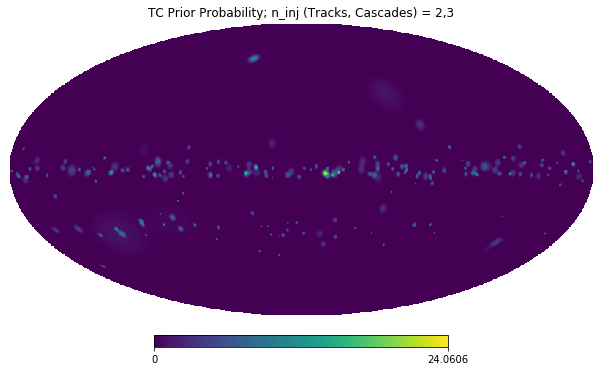

In [86]:
#resolution of healpy grid
NSIDE = 2**8
NPIX = hp.nside2npix(NSIDE)

#angle array of every point on the sky
m = np.arange(NPIX)
theta, phi = np.deg2rad(hp.pix2ang(nside=NSIDE, ipix=m, lonlat = True))
llh_sky = np.zeros(NPIX)

ninj_t = 2
ninj_c = 3

tracks = np.concatenate([gen(ninj_t, 2, 0, inra = np.pi/4, indec = np.pi/3),gen(200, 3.7, 0)])
cascs = np.concatenate([gen(ninj_c, 2, 1, inra = np.pi/4, indec = np.pi/3),gen(50, 3.7, 1)])


#goes through every point in the sky and finds the llh and and ntrack guess using defined func
for i in tqdm(range(NPIX)):
    llh_sky[i] = SMTopoAw(tracks, cascs, theta[i], phi[i])[0]
    
hp.mollview(llh_sky)
plt.title(("TC Prior Probability; n_inj (Tracks, Cascades) = {},{}".format(ninj_t,ninj_c)))
plt.show()